In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Download ID:
* Diabetics dataset : 1l71UNNM-KSpPfyWOC9meK0G1ZhRJ6M9K
    command line `!gdown --id 1l71UNNM-KSpPfyWOC9meK0G1ZhRJ6M9K`

In [ ]:
!gdown --id 1j6BFDUNNgJRxB9td9RQfqDo6SkPBgry1

Downloading...
From: https://drive.google.com/uc?id=1j6BFDUNNgJRxB9td9RQfqDo6SkPBgry1
To: /content/wine.rar
100% 1.36M/1.36M [00:00<00:00, 89.8MB/s]


In [ ]:
!gdown --id 1iwYF9yPht_y_cJ_Y6sQ0jf4omEi_8rl5

Downloading...
From: https://drive.google.com/uc?id=1iwYF9yPht_y_cJ_Y6sQ0jf4omEi_8rl5
To: /content/iris.zip
100% 573k/573k [00:00<00:00, 82.1MB/s]


In [ ]:
!unrar x /content/wine.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/wine.rar

Creating    wine                                                      OK
Creating    wine/1                                                    OK
Extracting  wine/1/0.png                                                   0%  OK 
Extracting  wine/1/1.png                                                   1%  OK 
Extracting  wine/1/10.png                                                  1%  OK 
Extracting  wine/1/11.png                                                  2%  OK 
Extracting  wine/1/12.png                                                  2%  OK 
Extracting  wine/1/13.png                                                  3%  OK 
Extracting  wine/1/14.png                                                  3%  OK 
Extracting  wine/1/15.png                                                  4%  OK 
Extracting  wi

In [ ]:
#!unzip /content/HeartDiseasesdataset.zip

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders  # or import split_folders
splitfolders.ratio("/content/wine", seed=1337, ratio=(.85,  .15), group_prefix=None) # default values

Copying files: 178 files [00:00, 6142.82 files/s]


###Import Libraries

In [ ]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
os.listdir("/content/output/val")

['3', '1', '2']

###Dataloaders

In [ ]:
# Data augmentation and normalization for training
# Just normalization/content/content/HeartDiseasesdataset for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/output/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset_sizes, class_names, device

({'train': 150, 'val': 28}, ['1', '2', '3'], device(type='cpu'))

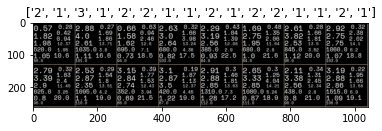

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Custom Functions

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_openml

In [ ]:
def train_simple_network_with_input_reshape(model, loss_func, train_loader, val_loader=None, score_funcs=None, 
                                            epochs=25, device="cpu", checkpoint_file=None):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    
    Here used the method provided in lecture only added code to flatten the inputs before passing to linear model
    """
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []
    
    #SGD is Stochastic Gradient Decent.
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
    
        model = model.train()#Put our model in training mode
        running_loss = 0.0
        
        y_true = []
        y_pred = []

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False):
      
            #Move the batch to the device we are using. 
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            batch_size = inputs.shape[0]

            # PyTorch stores gradients in a mutable data structure. So we need to set it to a clean state before we use it. 
            #Otherwise, it will have old information from a previous iteration
            optimizer.zero_grad()

            #flatten the input to fit in linear model
            y_hat = model(inputs) #this just computed f_Θ(x(i))#pass in a flattened view of inputs

            # Compute loss.
            loss = loss_func(y_hat, labels)

            loss.backward()# ∇_Θ just got computed by this one call!

            #Now we just need to update all the parameters! 
            optimizer.step()# Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)

            #Now we are just grabbing some information we would like to have
            running_loss += loss.item() * inputs.size(0)
            
            #moving labels & predictions back to CPU for computing / storing predictions
            labels = labels.detach().cpu().numpy()
            y_hat = y_hat.detach().cpu().numpy()
            for i in range(batch_size):
                y_true.append(labels[i])
                y_pred.append(y_hat[i,:])
        #end training epoch
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
            y_pred = np.argmax(y_pred, axis=1)
            
        for name, score_func in score_funcs.items():
            results["train " + name].append( score_func(y_true, y_pred) )
      
        if val_loader is None:
            pass
        else:#Lets find out validation performance as we go!
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!

            y_true = []
            y_pred = []
            
            running_loss = 0.0

            for inputs, labels in val_loader:
        
                #Move the batch to the device we are using. 
                inputs = inputs.to(device)
                labels = labels.to(device)

                #flatten the input to fit in linear model
                y_hat = model(inputs) #pass in a flattened view of inputs
            
                loss = loss_func(y_hat, labels)
                
                #Now we are just grabbing some information we would like to have
                running_loss += loss.item() * inputs.size(0)

                #moving labels & predictions back to CPU for computing / storing predictions
                labels = labels.detach().cpu().numpy()
                y_hat = y_hat.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(y_hat[i,:])
                        
            results["val loss"].append( running_loss )

            y_pred = np.asarray(y_pred)

            if y_pred.shape[1] > 1: #We have a classification problem, convert to labels
                y_pred = np.argmax(y_pred, axis=1)

            for name, score_func in score_funcs.items():
                results["val " + name].append( score_func(y_true, y_pred) )
                
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'c': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    res_dict = {}
    epoch_loss_list = []
    epoch_acc_list = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            epoch_loss_list.append(epoch_loss)
            epoch_acc_list.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            res_dict[phase] = epoch_acc_list
            


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_loss_list, epoch_acc_list,res_dict

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###Train & Validations

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.3)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft, ep_loss, ep_acc, res_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.8667 Acc: 0.7067
val Loss: 4.3299 Acc: 0.5357

Epoch 1/19
----------
train Loss: 0.1982 Acc: 0.9333
val Loss: 1.5541 Acc: 0.7857

Epoch 2/19
----------
train Loss: 0.1841 Acc: 0.9467
val Loss: 0.4143 Acc: 0.8214

Epoch 3/19
----------
train Loss: 0.1212 Acc: 0.9667
val Loss: 0.5458 Acc: 0.8571

Epoch 4/19
----------
train Loss: 0.1060 Acc: 0.9733
val Loss: 0.5316 Acc: 0.8214

Epoch 5/19
----------
train Loss: 0.0128 Acc: 1.0000
val Loss: 0.3734 Acc: 0.8929

Epoch 6/19
----------
train Loss: 0.0259 Acc: 0.9933
val Loss: 0.3226 Acc: 0.8929

Epoch 7/19
----------
train Loss: 0.0137 Acc: 1.0000
val Loss: 0.2802 Acc: 0.9643

Epoch 8/19
----------
train Loss: 0.0201 Acc: 1.0000
val Loss: 0.3168 Acc: 0.8929

Epoch 9/19
----------
train Loss: 0.0127 Acc: 0.9933
val Loss: 0.2577 Acc: 0.9643

Epoch 10/19
----------
train Loss: 0.0371 Acc: 0.9933
val Loss: 0.3009 Acc: 0.8929

Epoch 11/19
----------
train Loss: 0.0214 Acc: 1.0000
val Loss: 0.2708 Acc: 0.9286

Ep

In [ ]:
torch.save(model_ft, "model_resnet_wine.pth")
model_ft = torch.load("/content/model_resnet_wine.pth")


tensor([[ 9.,  0.,  0.],
        [ 1., 10.,  0.],
        [ 0.,  0.,  8.]])
tensor([1.0000, 0.9091, 1.0000])


Text(0.5, 69.0, 'Predicted label')

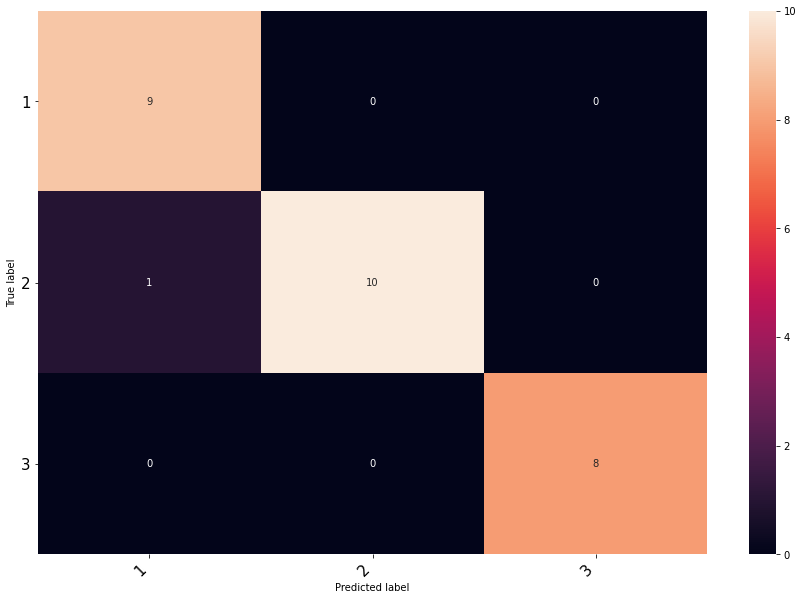

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))

# class_names = ['0','1']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
model_ft = models.googlenet(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.3)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

In [ ]:
model_ft, ep_loss, ep_acc, res_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.7726 Acc: 0.6467
val Loss: 0.8188 Acc: 0.6786

Epoch 1/19
----------
train Loss: 0.3767 Acc: 0.9000
val Loss: 0.8531 Acc: 0.7143

Epoch 2/19
----------
train Loss: 0.1983 Acc: 0.9467
val Loss: 0.4046 Acc: 0.8214

Epoch 3/19
----------
train Loss: 0.1402 Acc: 0.9467
val Loss: 0.3419 Acc: 0.9286

Epoch 4/19
----------
train Loss: 0.1036 Acc: 0.9800
val Loss: 0.1622 Acc: 0.9286

Epoch 5/19
----------
train Loss: 0.1630 Acc: 0.9467
val Loss: 0.1918 Acc: 0.9286

Epoch 6/19
----------
train Loss: 0.0576 Acc: 0.9800
val Loss: 0.2118 Acc: 0.9286

Epoch 7/19
----------
train Loss: 0.0273 Acc: 0.9933
val Loss: 0.1624 Acc: 0.9286

Epoch 8/19
----------
train Loss: 0.0252 Acc: 1.0000
val Loss: 0.1487 Acc: 0.9286

Epoch 9/19
----------
train Loss: 0.0262 Acc: 0.9933
val Loss: 0.1549 Acc: 0.9286

Epoch 10/19
----------
train Loss: 0.0172 Acc: 1.0000
val Loss: 0.1547 Acc: 0.9286

Epoch 11/19
----------
train Loss: 0.0199 Acc: 1.0000
val Loss: 0.1528 Acc: 0.9286

Ep

In [ ]:
torch.save(model_ft, "model_googlenet_wine.pth")
model_ft = torch.load("/content/model_googlenet_wine.pth")


tensor([[9., 0., 0.],
        [1., 9., 1.],
        [0., 0., 8.]])
tensor([1.0000, 0.8182, 1.0000])


Text(0.5, 69.0, 'Predicted label')

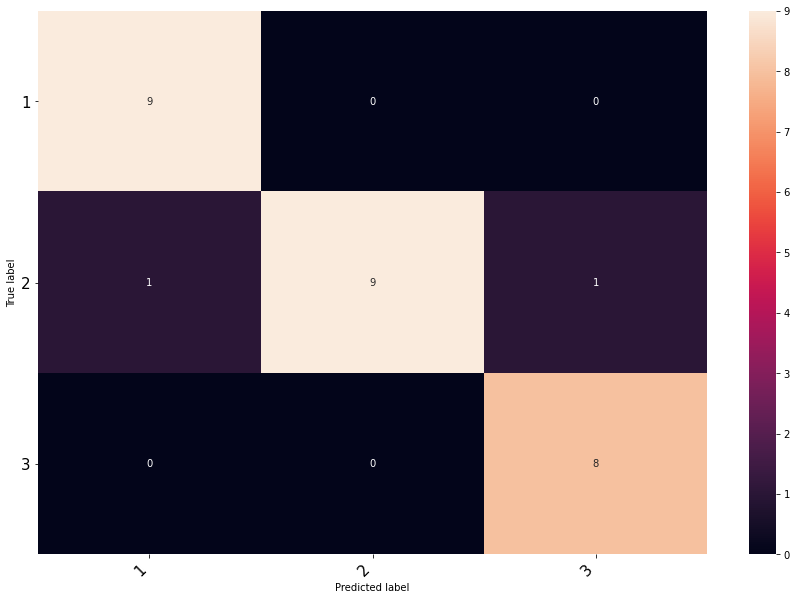

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))

# class_names = ['0','1']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
model_ft = models.densenet121(pretrained=True)
#num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.3)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

In [ ]:
model_ft, ep_loss, ep_acc, res_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 3.2532 Acc: 0.5600
val Loss: 0.4478 Acc: 0.8571

Epoch 1/19
----------
train Loss: 0.3478 Acc: 0.8933
val Loss: 1.6458 Acc: 0.6786

Epoch 2/19
----------
train Loss: 0.2130 Acc: 0.9467
val Loss: 2.6164 Acc: 0.6071

Epoch 3/19
----------
train Loss: 0.0892 Acc: 0.9800
val Loss: 2.5235 Acc: 0.6429

Epoch 4/19
----------
train Loss: 0.0482 Acc: 0.9800
val Loss: 1.6632 Acc: 0.8214

Epoch 5/19
----------
train Loss: 0.0271 Acc: 0.9933
val Loss: 0.4749 Acc: 0.8571

Epoch 6/19
----------
train Loss: 0.0230 Acc: 0.9933
val Loss: 0.1934 Acc: 0.8929

Epoch 7/19
----------
train Loss: 0.0453 Acc: 0.9867
val Loss: 0.1075 Acc: 0.9286

Epoch 8/19
----------
train Loss: 0.0226 Acc: 0.9933
val Loss: 0.1126 Acc: 0.8929

Epoch 9/19
----------
train Loss: 0.0346 Acc: 0.9933
val Loss: 0.1040 Acc: 0.9286

Epoch 10/19
----------
train Loss: 0.0163 Acc: 1.0000
val Loss: 0.1049 Acc: 0.9286

Epoch 11/19
----------
train Loss: 0.0112 Acc: 1.0000
val Loss: 0.0989 Acc: 0.9286

Ep

In [ ]:
torch.save(model_ft, "model_densenet_wine.pth")
model_ft = torch.load("/content/model_densenet_wine.pth")


tensor([[ 8.,  1.,  0.],
        [ 0., 11.,  0.],
        [ 0.,  0.,  8.]])
tensor([0.8889, 1.0000, 1.0000])


Text(0.5, 69.0, 'Predicted label')

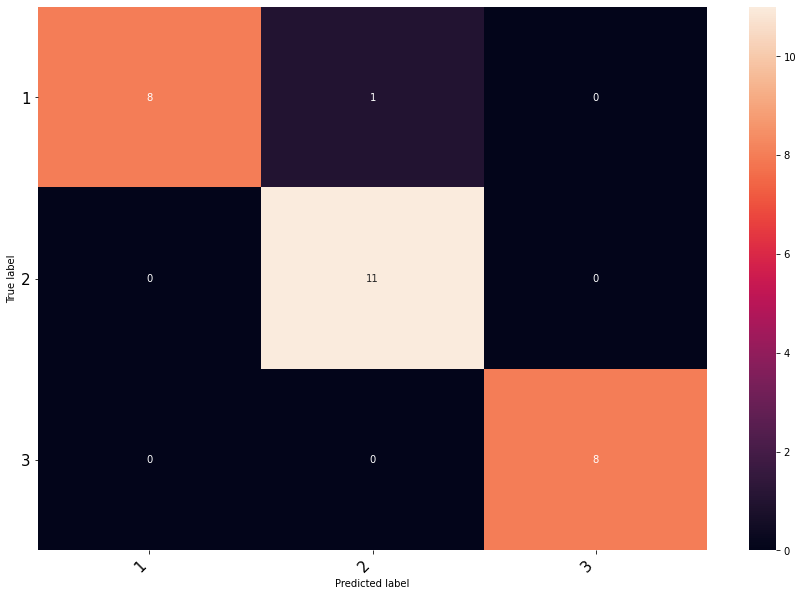

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))

# class_names = ['0','1']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

tensor([[ 8.,  1.,  0.],
        [ 0., 11.,  0.],
        [ 0.,  0.,  8.]])
tensor([0.8889, 1.0000, 1.0000])


Text(0.5, 69.0, 'Predicted label')

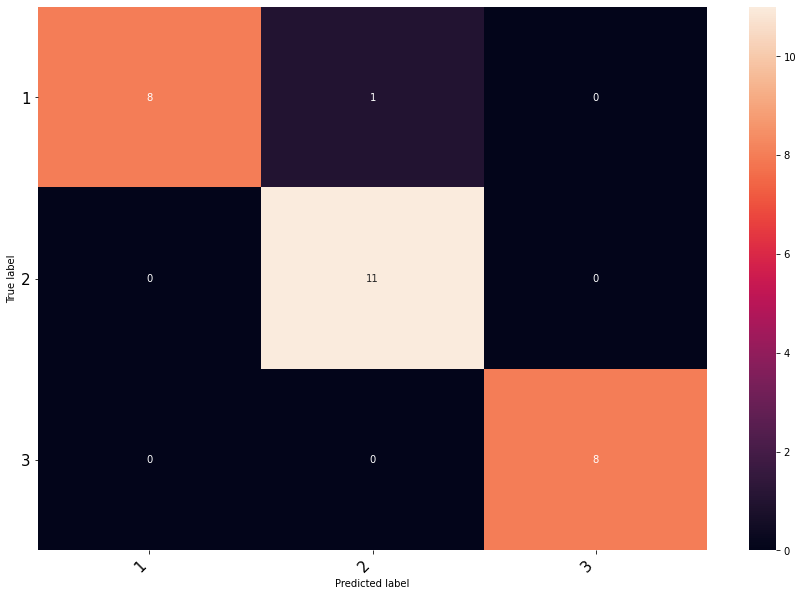

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))

# class_names = ['0','1']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
# loss_func = nn.CrossEntropyLoss()
# results_pd1 = train_simple_network_with_input_reshape(model_ft, loss_func, dataloaders['train'], epochs=25, val_loader=dataloaders['val'],
#                                                       checkpoint_file='model_ft_1.pt', score_funcs={'Acc':accuracy_score}, device=device)

In [ ]:
# sns.lineplot(x='epoch', y='train Acc', data=results_pd1, label='Train')
# sns.lineplot(x='epoch', y='val Acc', data=results_pd1, label='Validation')

In [ ]:
#pr, tpr, _ = roc_curve(y, y_score)
#roc_auc = auc(fpr, tpr)
print("average_precision_score : {}".format(average_precision_score(y, y_score)))
print("roc_auc_score : {}".format(str(roc_auc_score(y, y_score))))
print("accuracy : {}".format(str(accuracy_score(y, y_score))))

NameError: ignored

In [ ]:
nb_classes = len(class_names)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

print(confusion_matrix.diag()/confusion_matrix.sum(1))

plt.figure(figsize=(15,10))

# class_names = ['0','1']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [ ]:
#print('Test accuracy:{:.4f}'.format(correct.double() / dataset_sizes['val']))
print('Sensitivity: ', 100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]))
print('Specificity: ', 100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))
print('PPV: ', 100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]))
print('NPV: ', 100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]))

In [ ]:
def getConfusionMatrix(model, show_image=False):
    model.eval() #set the model to evaluation mode
    confusion_matrix=np.zeros((2,2),dtype=int) #initialize a confusion matrix
    num_images=dataloaders['val'] #size of the testset
    
    with torch.no_grad(): #disable back prop to test the model
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            #get predictions of the model
            outputs = model(inputs) 
            _, preds = torch.max(outputs, 1) 
            
            #get confusion matrix
            for j in range(inputs.size()[0]): 
                if preds[j]==1 and labels[j]==1:
                    term='TP'
                    confusion_matrix[0][0]+=1
                elif preds[j]==1 and labels[j]==0:
                    term='FP'
                    confusion_matrix[1][0]+=1
                elif preds[j]==0 and labels[j]==1:
                    term='FN'
                    confusion_matrix[0][1]+=1
                elif preds[j]==0 and labels[j]==0:
                    term='TN'
                    confusion_matrix[1][1]+=1
                #show image and its class in confusion matrix    
                if show_image:
                    print('predicted: {}'.format(class_names[preds[j]]))
                    print(term)
                    imshow(inputs.cpu().data[j])
                    print()
        #print results
        print('Confusion Matrix: ')
        print(confusion_matrix)
        print()
        print('Sensitivity: ', 100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[0][1]))
        print('Specificity: ', 100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0]))
        print('PPV: ', 100*confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]))
        print('NPV: ', 100*confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[0][1]))
        
        return confusion_matrix

In [ ]:
conf_mat = getConfusionMatrix(model_ft)
conf_mat


In [ ]:
# epochs= np.arange(start=0, stop=25, step=1)

# plt.plot(epochs, train_acc[0], 'g', label='Training acc')
# plt.plot(epochs, val_acc[0], 'b', label='validation acc')
# plt.title('Training and Validation acc')
# plt.xlabel('Epochs')
# plt.ylabel('acc')
# plt.legend()
# plt.show()

In [ ]:
## save the model...
torch.save(model_ft, "model_ft_diabetics_96.pth")   

In [ ]:
# visualize_model(model_ft)

###Convolutional Layer Fixed

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=50)

In [ ]:
torch.save(model_conv, "model_conv_diabetics_94.pth")

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()